# <center> Simulator </center>

Code from internship 2018.

In [1]:
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter

## 0. Setting parameters

In [2]:
N = 50 # nb users
nb_tirages = 10000

# lambdas = np.random.pareto(1.3, N)
# mus = np.random.pareto(1.3, N)

lambdas = [0.1 for n in range(N)]
mus = [0.1 for n in range(N)]

# lambdas = np.random.random(N)
# mus = np.random.random(N)

## 1. Timestamps creation
Creates list with lines (user, time, activity_type).

In [3]:
# timestamps list
timestamps = []

# generate events user by user
for j in range(N):
    
    # generate selfposts
    time = 0
    for n in range(nb_tirages):
        dice = random.expovariate(lambdas[j])
        time += dice
        timestamps.append((j, time, 'post'))
        
    # generate reposts
    time = 0
    for n in range(nb_tirages):
        dice = random.expovariate(mus[j])
        time += dice
        timestamps.append((j, time, 'repost'))

# we only keep the nb_tirages first events
timestamps = sorted(timestamps, key=itemgetter(1))[:nb_tirages]

Show the first timestamps.

In [4]:
timestamps[:10]

[(9, 0.19761178684143316, 'post'),
 (14, 0.22897749303630008, 'post'),
 (9, 0.27817540573473964, 'post'),
 (26, 0.5253316841652562, 'repost'),
 (3, 0.5629811737376177, 'repost'),
 (24, 0.5680854304938732, 'post'),
 (48, 0.6456781948044539, 'repost'),
 (40, 0.8036062177413145, 'post'),
 (16, 1.1077779333933808, 'repost'),
 (28, 1.2113021275080007, 'post')]

## 2. Trace generation
Creates trace (twid, uid, ts, rtid) from events list and user graph.

Parameters.

In [5]:
w = 5 / (N-1)
G = nx.gnp_random_graph(N, w, directed=True)
M = 1
K = 1
print("directed edge proba : w =", w)
print("nb edges : ", G.number_of_edges())
print("strong connectivity : ", nx.is_strongly_connected(G))

directed edge proba : w = 0.10204081632653061
nb edges :  275
strong connectivity :  True


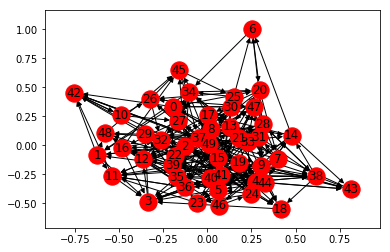

In [7]:
nx.draw_networkx(G, with_labels=True)

Write graph on file.

In [8]:
graph_out = open("../Datasets/leadgraph_test.txt", "w")
for n in G.nodes:
    graph_out.write(str(n))
    for p in G.predecessors(n):
        graph_out.write(" " + str(p))
    graph_out.write("\n")
graph_out.close()

Out file path for writing trace.

In [9]:
out = open("../Datasets/trace_test.txt", "w")

Initialization.

In [10]:
# leaders list creation from user graph
leaders = []
for i in range(N):
    leaders.append(list(G.predecessors(i)))

# on initialise les walls et newsfeed en listes vides
wall = {}
news = {}
for i in range(N):     
    wall[i] = []
    news[i] = []

# on crée une variable next_id qui contient l'id du prochain post
next_id = 0

# on crée un compteur de temps
time = 0

# on définit le nb d'étapes comme la longueur de la liste de timestamps
nb_etapes = len(timestamps)

Iterations: events.

In [11]:
for n in range(nb_etapes):

    # on définit next_event_time, user, type
    next_event_user = timestamps[n][0]
    next_event_time = timestamps[n][1]
    next_event_type = timestamps[n][2]

    # on définit le new_post. GO prochain event si retweet alors que newsfeed vide
    if next_event_type == 'repost':
        if len(news[next_event_user]) == 0:
            continue
        else:
            new_post = random.choice(news[next_event_user])
            new_post[2] += 1      # on incrémente le nombre de reposts du tweet qui est retweeté
    else:
        new_post = [next_id, next_event_user, 0]

    # on update le wall du next event user et nb post wall
    if len(wall[next_event_user]) == K:
        deleted_post = random.choice(wall[next_event_user])
        wall[next_event_user].remove(deleted_post)
    wall[next_event_user].insert(0, new_post)

    # on update les newsfeed des followers du next event user et leurs nb_posts_news
    for j in range(N):
        if next_event_user in leaders[j]:
            if len(news[j]) == M:
                deleted_post = random.choice(news[j])
                news[j].remove(deleted_post)
            news[j].insert(0, new_post)

    # write event to out
    if next_event_type == 'repost':
        out.write("{} {} {} {}\n".format(next_id, time, next_event_user, new_post[0]))
    else:
        out.write("{} {} {} -1\n".format(next_id, time, next_event_user))

    # on update le temps et next_id
    time = next_event_time
    next_id += 1
    
# close
out.close()